In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

# 2017-02-26-支付数据集探索

# toc

- [用户浏览-数据观察和脏数据处理](#用户浏览-数据观察和脏数据处理)

### 用户浏览按照时间进行统计画图


In [8]:
data_dir = "/home/chester/data/koubei/dataset/dataset/"
df = pd.read_csv(data_dir +  "user_pay.txt",delimiter=",",names=["user_id","shop_id","ts"], parse_dates=["ts"])\
    .sample(frac=0.1,replace=False)



In [10]:
print "总用户支付量为 %d," % (df.user_id.count())
print "总用户数(去重)为 %d," % (df.user_id.unique().size)
print "总商店数(去重)为 %d," % (df.shop_id.unique().size)
df_date = df.ts.dt.date
print "涉及时间长度为 %d 天,起止时间为 %s --- %s" %(df_date.unique().size,df_date.min(),df_date.max())

总用户支付量为 6967411,
总用户数(去重)为 4662501,
总商店数(去重)为 2000,
涉及时间长度为 493 天,起止时间为 2015-06-26 --- 2016-10-31


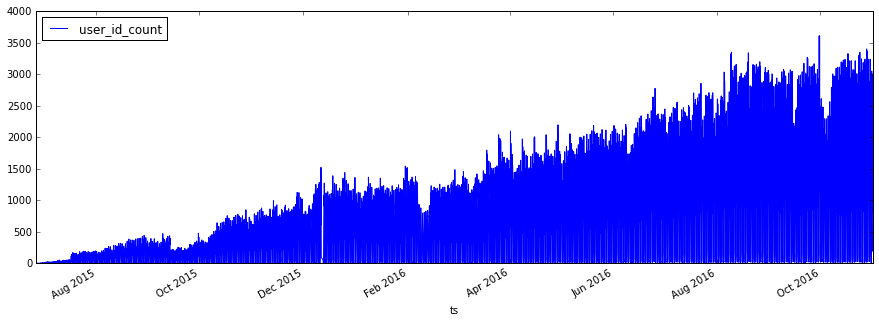

In [32]:
ts_group_df  = df.groupby("ts").agg({"user_id":np.size})
ts_group_df.rename(columns = {"user_id":"user_id_count"},inplace=True)
ts_group_df.sort_index().plot(figsize=(15,5))

为什么浏览量有两个异常的地方,支付数据为什么没有?????


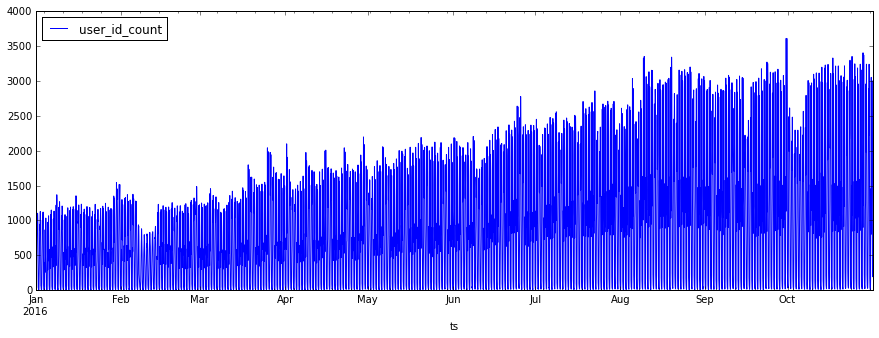

In [15]:
ts_group_df["2016"].plot(figsize=(15,5))
print "为什么浏览量有两个异常的地方,支付数据为什么没有?????"

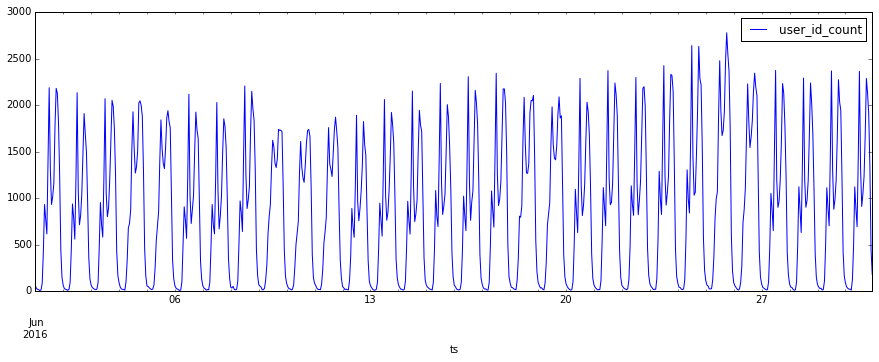

In [14]:
ts_group_df["2016-06"].plot(figsize=(15,5))


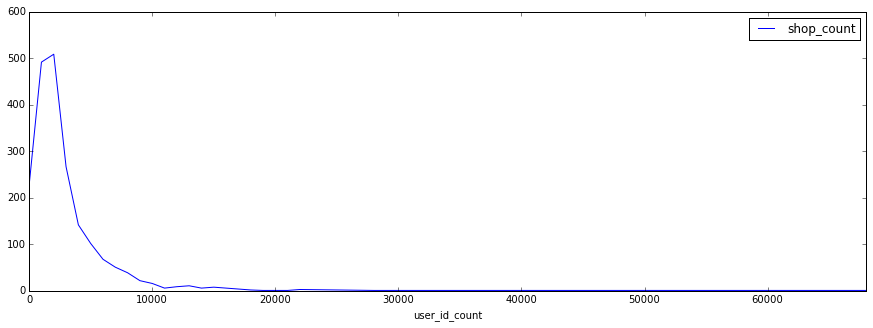

In [17]:
shop_group_df  = df.groupby("shop_id").agg({"user_id":np.size})
shop_group_df.rename(columns={"user_id":"user_id_count"},inplace=True)
shop_group_df_user_group = shop_group_df.applymap(lambda x: int(float(x)/1000)*1000)\
    .groupby("user_id_count").agg({"user_id_count":np.size}).rename(columns={"user_id_count":"shop_count"})
# print "横轴是用户浏览量,纵轴是商店数量,"
shop_group_df_user_group.plot(figsize=(15,5))

### 周统计

下图横轴为周Monday=0, Sunday=6,纵轴为该weekday的平均用户数
基本没有什么模式,从众数来看,因为众数非常平稳,虽然从均值来看周模式差别明显,但是均值并不是一个好的指标


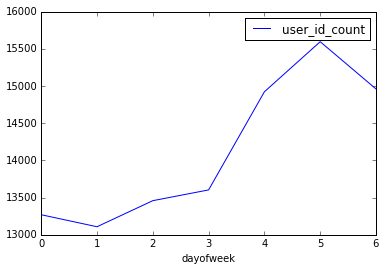

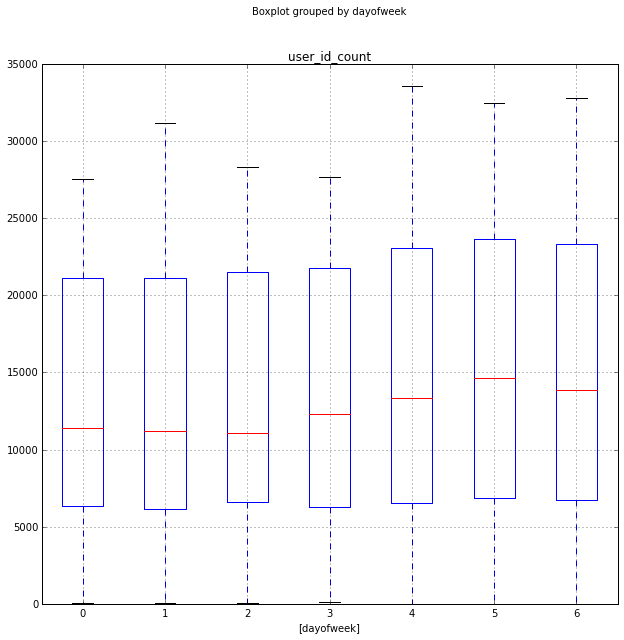

In [34]:
ts_group_df_noexception = ts_group_df.copy()
ts_group_df_noexception["date"] = ts_group_df_noexception.index.to_series().dt.date
date_group_df_noexception = ts_group_df_noexception.groupby("date").agg({"user_id_count":np.sum})
date_group_df_noexception.index = pd.DatetimeIndex(date_group_df_noexception.index)
date_group_df_noexception["dayofweek"] = date_group_df_noexception.index.to_series().dt.dayofweek
date_group_df_noexception.groupby("dayofweek").agg({"user_id_count":np.mean}).plot() #Monday=0, Sunday=6
date_group_df_noexception.boxplot(by="dayofweek",figsize=(10,10))
print "下图横轴为周Monday=0, Sunday=6,纵轴为该weekday的平均用户数"
print "基本没有什么模式,从众数来看,因为众数非常平稳,虽然从均值来看周模式差别明显,但是均值并不是一个好的指标"

### 月模式

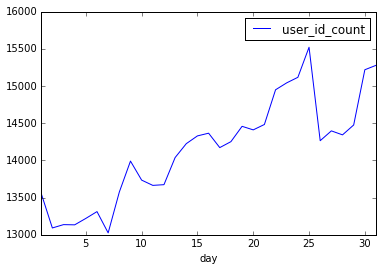

In [35]:
date_group_df_noexception["day"] = date_group_df_noexception.index.to_series().dt.day
date_group_df_noexception.groupby("day").agg({"user_id_count":np.mean}).plot() #Monday=0, Sunday=6


### 天模式

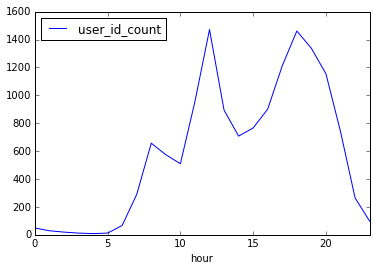

In [36]:
ts_group_df_noexception["hour"] = ts_group_df_noexception.index.to_series().dt.hour
ts_group_df_noexception.groupby("hour").agg({"user_id_count":np.mean}).plot() #Monday=0, Sunday=6

# 店模式
### 商店分级

In [38]:
#对店进行分级 3000,(总浏览量) 3000以上的为优质商店
base_shop = shop_group_df[shop_group_df.user_id_count<3000].index
premium_shop = shop_group_df[shop_group_df.user_id_count>=3000].index
# df[df.shop_id in premium_shop]
base_median = df[df.shop_id.isin(base_shop)].groupby("shop_id").agg({"user_id":np.size}).median()

premium_median = df[df.shop_id.isin(premium_shop)].groupby("shop_id").agg({"user_id":np.size}).median()

print "基本商店用户支付量中位数%d" % (base_median)
print "优质商店支付量中位数%d" % (premium_median)

基本商店用户支付量中位数1804
优质商店支付量中位数4849


### 商店周模式聚类
周模式进行聚类

In [41]:
dayofweek_mode_df = df.copy()
dayofweek_mode_df["dayofweek"] = dayofweek_mode_df.ts.dt.dayofweek

shop_dayofweek_pivot_df = pd.pivot_table(dayofweek_mode_df,values="user_id",index="shop_id",columns="dayofweek",aggfunc=np.size)
shop_dayofweek_pivot_df.fillna(0,inplace=True)
shop_dayofweek_pivot_df_normalized = shop_dayofweek_pivot_df.apply(lambda x:x/x.sum(),axis=1)

不同的模式


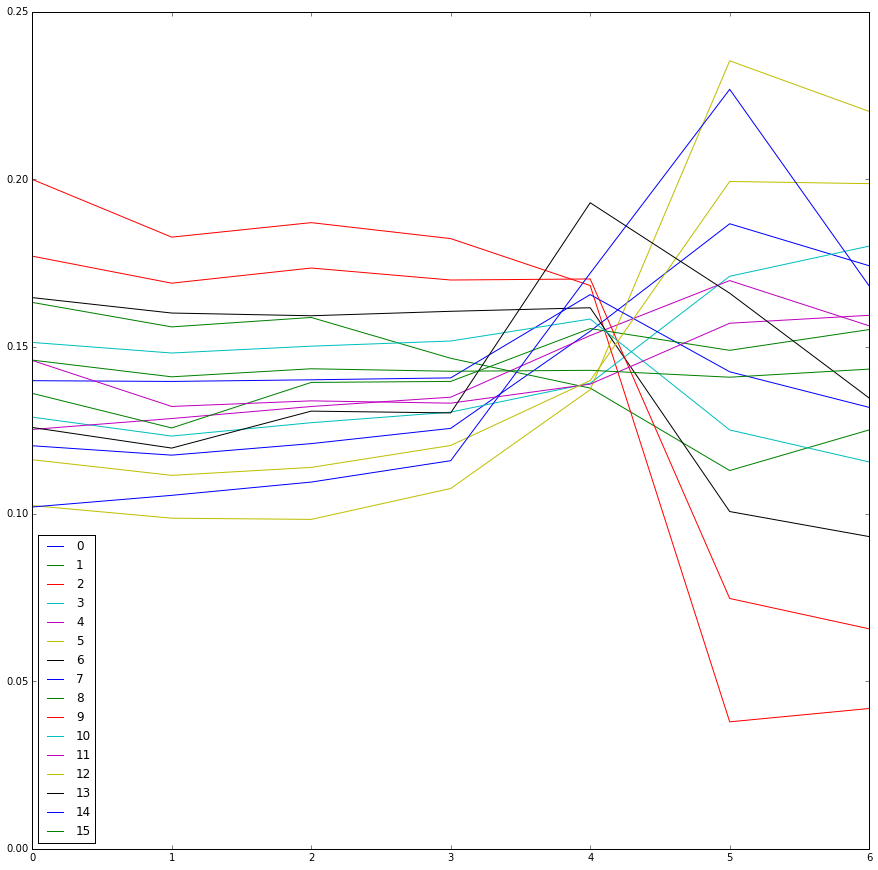

In [43]:
from sklearn.cluster import KMeans
cluster_handle = KMeans(n_clusters=16)
cluster_handle.fit(shop_dayofweek_pivot_df_normalized.values)
pd.DataFrame(cluster_handle.cluster_centers_).transpose().plot(figsize=(15,15))

print "不同的模式"

### 商店天模式聚类

In [47]:
hour_mode_df = df.copy()
hour_mode_df["hour"] = hour_mode_df.ts.dt.hour
shop_hour_pivot_df = pd.pivot_table(hour_mode_df,values="user_id",index="shop_id",columns="hour",aggfunc=np.size)
shop_hour_pivot_df.fillna(0,inplace=True)
shop_hour_pivot_df_normalized = shop_hour_pivot_df.apply(lambda x:x/x.sum(),axis=1)

In [48]:
shop_hour_pivot_df.values
from sklearn.cluster import KMeans
cluster_handle = KMeans(n_clusters=16)
cluster_handle.fit(shop_hour_pivot_df_normalized.values)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=16, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

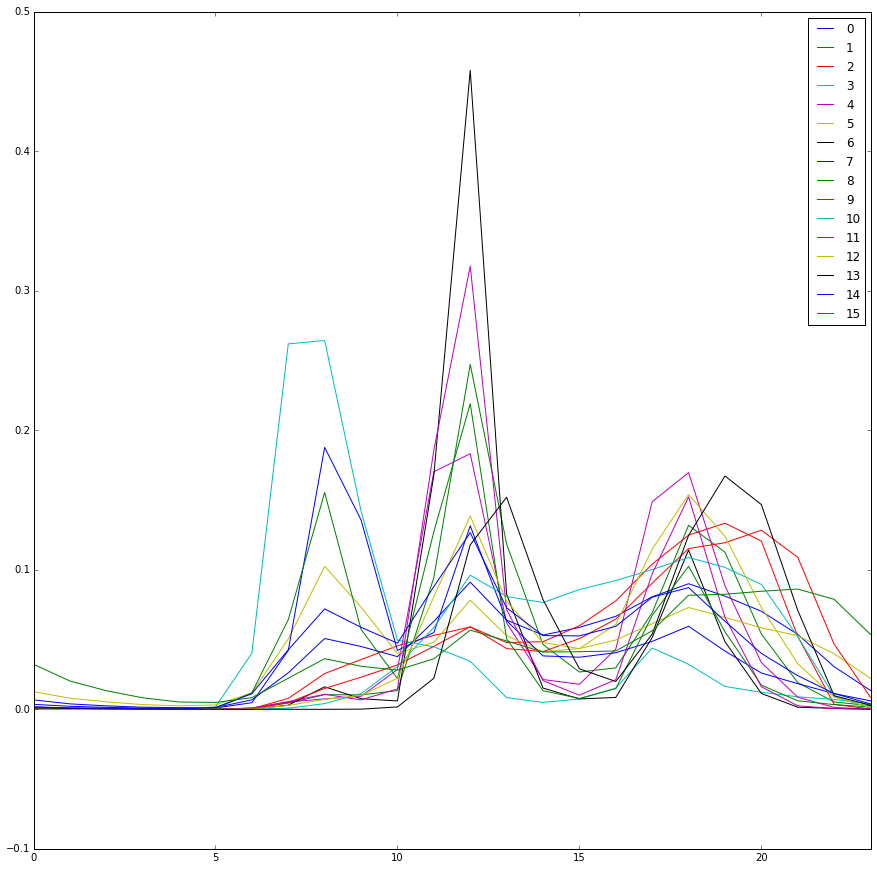

In [49]:

pd.DataFrame(cluster_handle.cluster_centers_).transpose().plot(figsize=(15,15))


### 用户对商店的重复支付模式
可能从中挖出复购的模式

In [50]:
user_shop_repeat_view =  df.copy()
user_cnt = user_shop_repeat_view.groupby("shop_id").agg({"user_id":np.size})
unique_user_cnt = user_shop_repeat_view.groupby("shop_id").agg({"user_id":lambda x:np.size(np.unique(x))})

# user_cnt.join(unique_user_cnt,on="index")
shop_view_user_count = user_cnt.merge(unique_user_cnt, left_index=True,right_index=True)

shop_view_user_count["unique_user_rate"] = shop_view_user_count["user_id_y"]/shop_view_user_count["user_id_x"]

比例为,支付量中,去重用户数量的比例


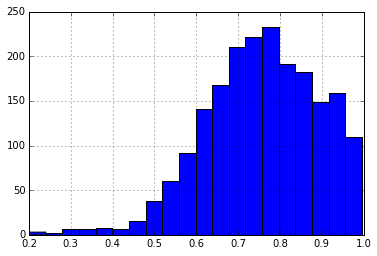

In [52]:
shop_view_user_count["unique_user_rate"].hist(bins=20)
print "比例为,支付量中,去重用户数量的比例"

### 商店的留存描述

In [53]:

agg_cnt = lambda x:{ k:v for (k,v) in \
    pd.DataFrame(x).groupby("user_id")\
    .agg({"user_id":np.size}).groupby("user_id").agg({"user_id":np.size})["user_id"].to_dict().iteritems()
    if k<=10}

tmp_agg_cnt = user_shop_repeat_view.groupby("shop_id").agg({"user_id":agg_cnt})

shop_view_cnt_user_cnt = pd.DataFrame.from_dict(tmp_agg_cnt["user_id"].to_dict(),orient="index")
## 需修改为>=10的全部归到10上

In [54]:
shop_view_cnt_user_cnt_normalized = shop_view_cnt_user_cnt.fillna(0).apply(lambda x:x/x.sum(),axis=1)

from sklearn.cluster import KMeans
cluster_handle = KMeans(n_clusters=3)
cluster_handle.fit(shop_view_cnt_user_cnt_normalized.values)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

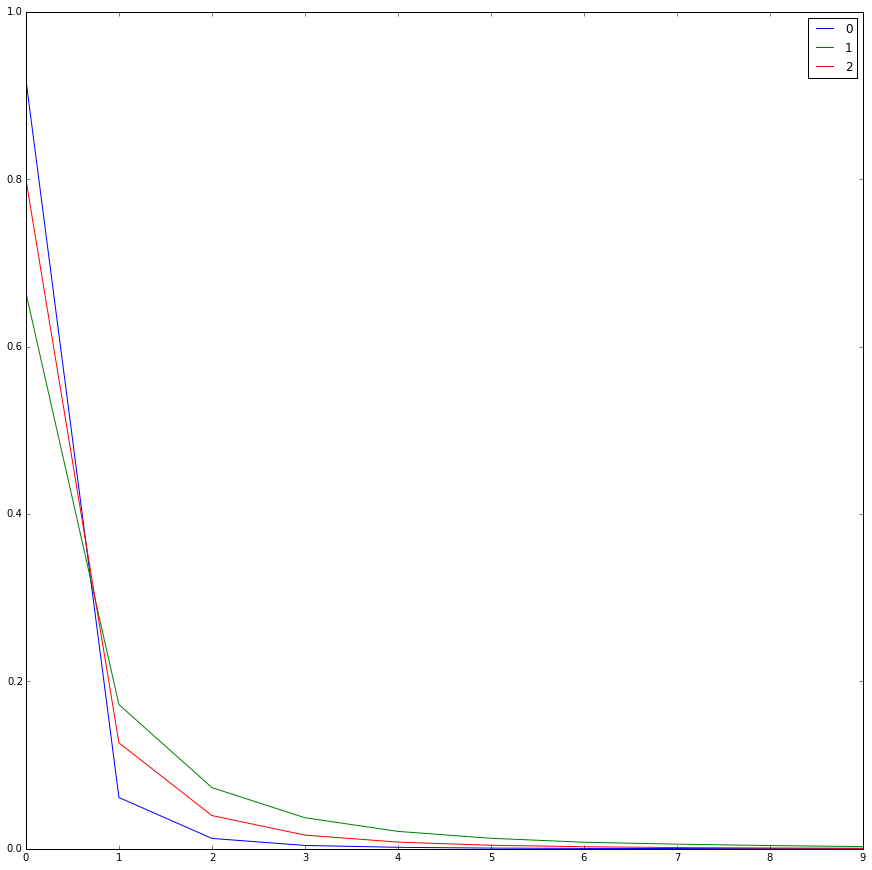

In [55]:

pd.DataFrame(cluster_handle.cluster_centers_).transpose().plot(figsize=(15,15))
#模式并不是很明显,不过单次访问的比例可以作为一个商店的特征

横轴为用户数,纵轴为用户在商店的支付次数,纵轴为所有商店的box plot


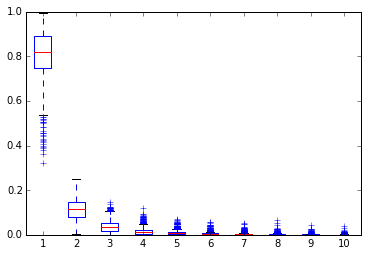

In [57]:
shop_view_cnt_user_cnt_normalized.plot(kind="box")
print "横轴为用户数,纵轴为用户在商店的支付次数,纵轴为所有商店的box plot"